In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
keras = tf.keras

In [2]:
def plot_series(time,series,format="-",start=0,end=None,label=None):
    plt.plot(time[start:end], series[start:end],format,label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

In [3]:
def trend(time,slope=0):
    return slope*time

In [4]:
#seasonal Data
def seasonal_pattern(season_time):
    return np.where(season_time< 0.4,np.cos(season_time*2*np.pi),
                   1/np.exp(3*season_time))

In [5]:
def seasonality(time,period,amplitude=1,phase=0):
    season_time = ((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

In [6]:
# noise
def white_noise(time,noise_level=1,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [7]:
time = np.arange(4*365+1)
slope = 0.05
baseline = 10
amplitude = 40

In [8]:
series = baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)
noise_level = 5
noise = white_noise(time,noise_level,seed=42)
series += noise

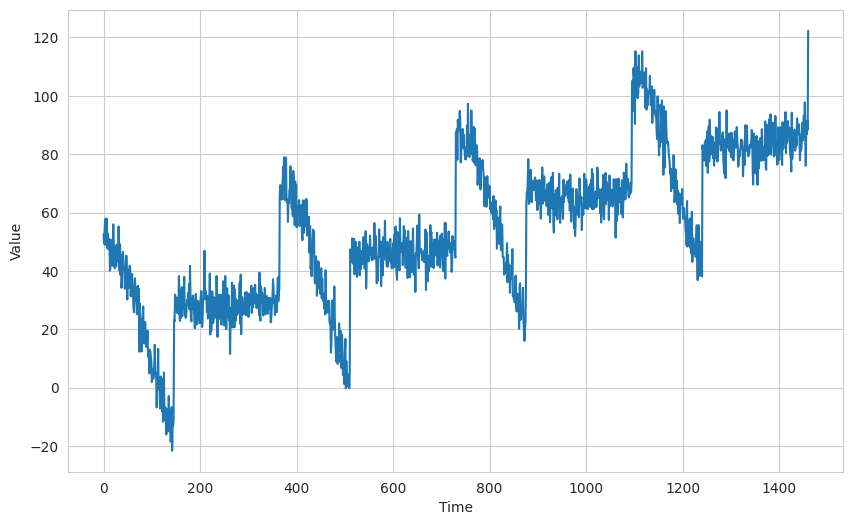

In [9]:
plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

In [10]:
def window_dataset(series,window_size,batch_size=32,shuffle_buffer=100):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1,shift=1,drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window:(window[:-1],window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [11]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30

In [12]:
split_time = 1000
time_train = time[:split_time]
X_train = series[:split_time]
time_valid = time[split_time:]
X_valid = series[split_time:]

In [13]:
train_set = window_dataset(X_train,window_size,batch_size=128)

In [14]:
train_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [15]:
model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[None]),
    keras.layers.SimpleRNN(100,return_sequences= True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200)
])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 100)         10200     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 30401 (118.75 KB)
Trainable params: 30401 (118.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7*10**(epoch/20))

In [18]:
optimizer = keras.optimizers.SGD(learning_rate=1e-7,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [19]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 4s 166ms/step - loss: 56.7160 - mae: 57.2159 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 1s 66ms/step - loss: 30.1374 - mae: 30.6338 - lr: 1.1220e-07
Epoch 3/100
8/8 [==============================] - 1s 69ms/step - loss: 35.1093 - mae: 35.6082 - lr: 1.2589e-07
Epoch 4/100
8/8 [==============================] - 1s 67ms/step - loss: 30.9863 - mae: 31.4833 - lr: 1.4125e-07
Epoch 5/100
8/8 [==============================] - 1s 79ms/step - loss: 24.4437 - mae: 24.9337 - lr: 1.5849e-07
Epoch 6/100
8/8 [==============================] - 1s 79ms/step - loss: 22.4636 - mae: 22.9594 - lr: 1.7783e-07
Epoch 7/100
8/8 [==============================] - 1s 91ms/step - loss: 20.2880 - mae: 20.7801 - lr: 1.9953e-07
Epoch 8/100
8/8 [==============================] - 1s 84ms/step - loss: 19.1642 - mae: 19.6551 - lr: 2.2387e-07
Epoch 9/100
8/8 [==============================] - 1s 130ms/step - loss: 18.0065 - mae: 18.4975 - lr: 2

(1e-07, 0.0001, 0.0, 30.0)

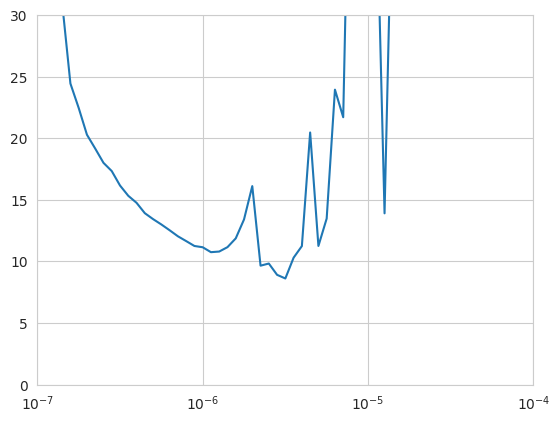

In [20]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-7,1e-4,0,30])

In [21]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30
train_set = window_dataset(X_train,window_size,batch_size=128)
valid_set = window_dataset(X_valid,window_size,batch_size=128)

In [22]:
model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[None]),
    keras.layers.SimpleRNN(100,return_sequences=True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

In [23]:
optimizer = keras.optimizers.SGD(learning_rate=1.5e-6,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [24]:
early_stopping = keras.callbacks.EarlyStopping(patience=5)
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5",
                                                  save_best_only=True)

In [25]:
model.fit(train_set,epochs=500,
         validation_data=valid_set,
         callbacks=[early_stopping,model_checkpoint])

Epoch 1/500
8/8 [==============================] - 3s 138ms/step - loss: 68.9718 - mae: 69.4714 - val_loss: 29.0662 - val_mae: 29.5647
Epoch 2/500


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 1s 57ms/step - loss: 46.1395 - mae: 46.6366 - val_loss: 16.7461 - val_mae: 17.2421
Epoch 3/500
8/8 [==============================] - 0s 57ms/step - loss: 57.6062 - mae: 58.1050 - val_loss: 68.4614 - val_mae: 68.9614
Epoch 4/500
8/8 [==============================] - 0s 52ms/step - loss: 18.8409 - mae: 19.3366 - val_loss: 15.5556 - val_mae: 16.0488
Epoch 5/500
8/8 [==============================] - 1s 69ms/step - loss: 21.8361 - mae: 22.3326 - val_loss: 10.1639 - val_mae: 10.6519
Epoch 6/500
8/8 [==============================] - 1s 62ms/step - loss: 28.1505 - mae: 28.6482 - val_loss: 26.6525 - val_mae: 27.1524
Epoch 7/500
8/8 [==============================] - 1s 59ms/step - loss: 24.1453 - mae: 24.6402 - val_loss: 34.4759 - val_mae: 34.9759
Epoch 8/500
8/8 [==============================] - 1s 63ms/step - loss: 21.5612 - mae: 22.0558 - val_loss: 22.6051 - val_mae: 23.1041
Epoch 9/500
8/8 [==============================] - 0s 54ms/step - loss: 12

In [26]:
model = keras.models.load_model("my_checkpoint.h5")

In [27]:
def model_forcast(model,series,window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w:w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [28]:
rnn_forecast = model_forcast(model,series[split_time-window_size:-1],window_size)[:,0]

15/15 [==============================] - 1s 12ms/step


8.752768

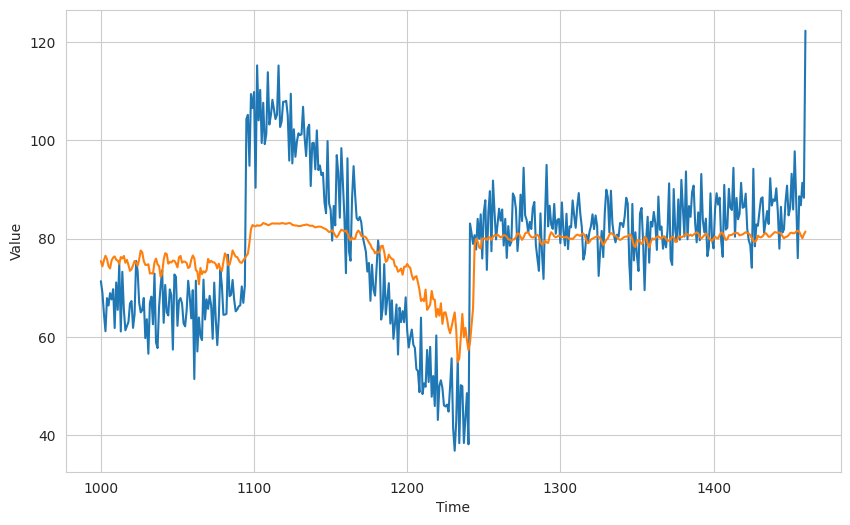

In [29]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)
print('\n')
keras.metrics.mean_absolute_error(X_valid,rnn_forecast).numpy()

# Sequence_to_Sequence

In [30]:
def seq2_seq_window_dataset(series,window_size,batch_size=32,shuffle_buffer=1000):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1],w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [31]:
for X_batch,Y_batch in seq2_seq_window_dataset(tf.range(10),3,batch_size=1):
    print("X : ",X_batch.numpy())
    print("Y : ",Y_batch.numpy())

X :  [[[4]
  [5]
  [6]]]
Y :  [[[5]
  [6]
  [7]]]
X :  [[[1]
  [2]
  [3]]]
Y :  [[[2]
  [3]
  [4]]]
X :  [[[0]
  [1]
  [2]]]
Y :  [[[1]
  [2]
  [3]]]
X :  [[[5]
  [6]
  [7]]]
Y :  [[[6]
  [7]
  [8]]]
X :  [[[2]
  [3]
  [4]]]
Y :  [[[3]
  [4]
  [5]]]
X :  [[[6]
  [7]
  [8]]]
Y :  [[[7]
  [8]
  [9]]]
X :  [[[3]
  [4]
  [5]]]
Y :  [[[4]
  [5]
  [6]]]


In [32]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [33]:
window_size = 30
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)

In [34]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(100,return_sequences=True,input_shape=[None,1]),
    keras.layers.SimpleRNN(100,return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x:x*200)
])

In [35]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7*10**(epoch/30))

In [36]:
optimizer = keras.optimizers.SGD(learning_rate=1e-7,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [37]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 36ms/step - loss: 139.0266 - mae: 139.5263 - lr: 1.0000e-07
Epoch 2/100
8/8 [==============================] - 0s 35ms/step - loss: 72.6468 - mae: 73.1456 - lr: 1.0798e-07
Epoch 3/100
8/8 [==============================] - 0s 33ms/step - loss: 72.7506 - mae: 73.2498 - lr: 1.1659e-07
Epoch 4/100
8/8 [==============================] - 0s 39ms/step - loss: 46.7119 - mae: 47.2095 - lr: 1.2589e-07
Epoch 5/100
8/8 [==============================] - 0s 35ms/step - loss: 33.9808 - mae: 34.4762 - lr: 1.3594e-07
Epoch 6/100
8/8 [==============================] - 0s 35ms/step - loss: 23.0377 - mae: 23.5324 - lr: 1.4678e-07
Epoch 7/100
8/8 [==============================] - 0s 31ms/step - loss: 20.1654 - mae: 20.6575 - lr: 1.5849e-07
Epoch 8/100
8/8 [==============================] - 0s 34ms/step - loss: 19.3729 - mae: 19.8649 - lr: 1.7113e-07
Epoch 9/100
8/8 [==============================] - 0s 32ms/step - loss: 17.8188 - mae: 18.3091 - lr: 1

(1e-07, 0.0001, 0.0, 30.0)

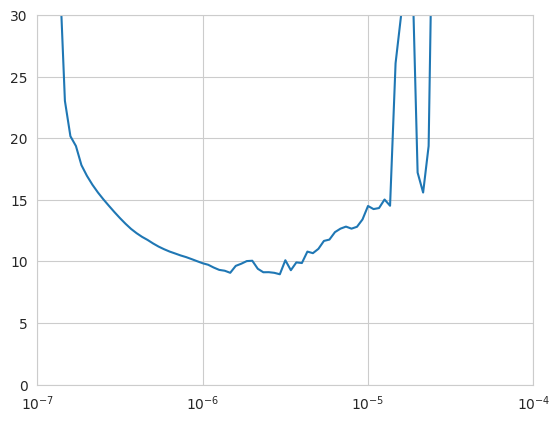

In [38]:
plt.semilogx(history.history['lr'],history.history["loss"])
plt.axis([1e-7,1e-4,0,30])

In [39]:
# Second

In [40]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [41]:
window_size = 30
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)
valid_set = seq2_seq_window_dataset(X_valid,window_size,batch_size=128)

In [42]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(100,return_sequences=True,input_shape=[None,1]),
    keras.layers.SimpleRNN(100,return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x:x*200)
])

In [43]:
optimizer = keras.optimizers.SGD(learning_rate=1e-6,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [44]:
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set,epochs=500,
         validation_data=valid_set,
         callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 3s 106ms/step - loss: 55.4763 - mae: 55.9739 - val_loss: 18.7262 - val_mae: 19.2155
Epoch 2/500
8/8 [==============================] - 1s 59ms/step - loss: 39.8209 - mae: 40.3186 - val_loss: 58.4474 - val_mae: 58.9471
Epoch 3/500
8/8 [==============================] - 1s 57ms/step - loss: 28.6331 - mae: 29.1284 - val_loss: 19.2130 - val_mae: 19.7067
Epoch 4/500
8/8 [==============================] - 1s 58ms/step - loss: 20.7873 - mae: 21.2802 - val_loss: 13.8711 - val_mae: 14.3632
Epoch 5/500
8/8 [==============================] - 1s 57ms/step - loss: 18.0669 - mae: 18.5586 - val_loss: 13.7054 - val_mae: 14.1995
Epoch 6/500
8/8 [==============================] - 1s 56ms/step - loss: 15.4182 - mae: 15.9077 - val_loss: 13.9620 - val_mae: 14.4543
Epoch 7/500
8/8 [==============================] - 1s 58ms/step - loss: 13.5679 - mae: 14.0546 - val_loss: 13.8491 - val_mae: 14.3432
Epoch 8/500
8/8 [==============================] - 1s 57ms/st

In [45]:
rnn_forecast = model_forcast(model,series[...,np.newaxis],window_size)

45/45 [==============================] - 2s 18ms/step


In [46]:
rnn_forecast = rnn_forecast[split_time-window_size:-1,-1,0]

5.412994




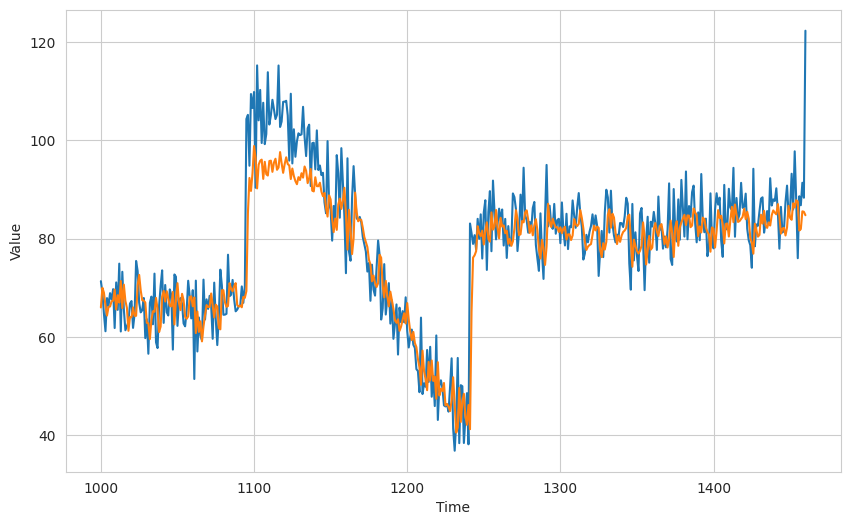

In [47]:
print(keras.metrics.mean_absolute_error(X_valid,rnn_forecast).numpy())
print('\n')
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)

# StateFull RNN

In [48]:
def sequential_window_dataset(series,window_size):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift=window_size,drop_remainder=True)
    ds = ds.flat_map(lambda window:window.batch(window_size+1))
    ds = ds.map(lambda window:(window[:-1],window[1:]))
    return ds.batch(1).prefetch(1)

In [49]:
for X_batch,Y_batch in sequential_window_dataset(tf.range(10),3):
    print(X_batch.numpy(),Y_batch.numpy())

[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


In [50]:
class RestStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self,epoch,logs):
        self.model.reset_states()

In [51]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [52]:
window_size = 30
train_set = sequential_window_dataset(X_train,window_size)

In [53]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(100,return_sequences=True,stateful=True,batch_input_shape=[1,None,1]),
    keras.layers.SimpleRNN(100,return_sequences=True,stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200.0)
])

In [54]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/30))

In [55]:
reset_states = RestStatesCallback()

In [56]:
optimizer = keras.optimizers.SGD(learning_rate=1e-8,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [57]:
history = model.fit(train_set,epochs=100,
                   callbacks=[lr_schedule,reset_states])

Epoch 1/100
33/33 [==============================] - 2s 13ms/step - loss: 330.6765 - mae: 331.1765 - lr: 1.0000e-08
Epoch 2/100
33/33 [==============================] - 0s 11ms/step - loss: 270.8361 - mae: 271.3361 - lr: 1.0798e-08
Epoch 3/100
33/33 [==============================] - 0s 12ms/step - loss: 194.2604 - mae: 194.7604 - lr: 1.1659e-08
Epoch 4/100
33/33 [==============================] - 0s 11ms/step - loss: 111.7938 - mae: 112.2938 - lr: 1.2589e-08
Epoch 5/100
33/33 [==============================] - 0s 12ms/step - loss: 37.5891 - mae: 38.0861 - lr: 1.3594e-08
Epoch 6/100
33/33 [==============================] - 0s 11ms/step - loss: 18.8417 - mae: 19.3337 - lr: 1.4678e-08
Epoch 7/100
33/33 [==============================] - 0s 12ms/step - loss: 17.3307 - mae: 17.8201 - lr: 1.5849e-08
Epoch 8/100
33/33 [==============================] - 0s 11ms/step - loss: 17.0948 - mae: 17.5842 - lr: 1.7113e-08
Epoch 9/100
33/33 [==============================] - 0s 11ms/step - loss: 16.902

In [58]:
#model = keras.models.load_model("my_checkpoint.h5")
#model.reset_states()

In [59]:
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, : ,np.newaxis])
rnn_forecast = rnn_forecast[0, split_time -1 :-1, 0]

1/1 [==============================] - 0s 326ms/step


In [60]:
rnn_forecast.shape

(461,)

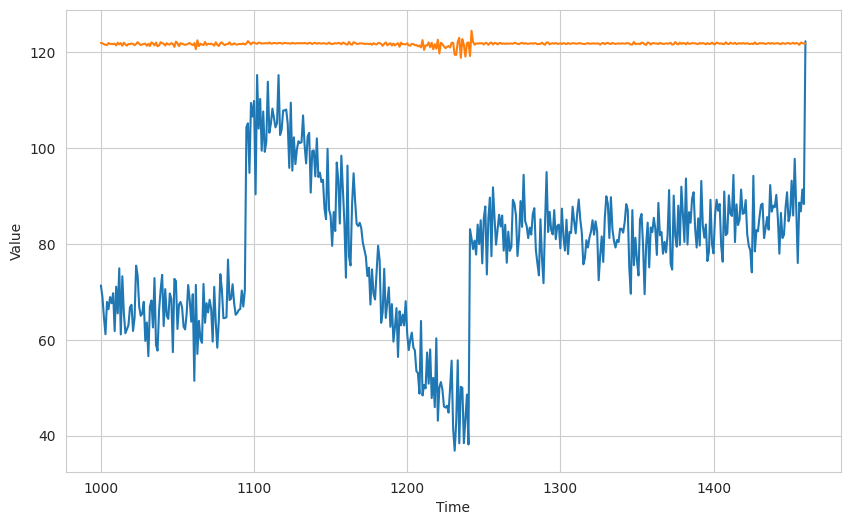

In [61]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)